## python画图函数的常见用法
**13 August 2019 by MiniUFO**

---
[TOC]

---

### 1. 提取地转流场
地转流场可以通过AVISO卫星高度计资料观测的海表高度（h）进行差分计算得到：
> $$\mathbf u_g=\frac{g}{f}\mathbf k\times\nabla h \tag{1}$$

这里我们直接使用它提供的网格产品，避免了处理赤道地区科氏参数$f$接近0的情况。但由于地转流场不是无辐散的，需要通过订正使得流场无辐散。根据Helmholtz理论，任何矢量场可以分解为旋转流场（散度为0）和辐散流场（旋度为0）两部分：
> $$\mathbf u=\nabla\phi+\mathbf k\times\nabla \psi \tag{2}$$

因此，我们可以利用MITgcm的2D solver来求解上面的流函数和势函数，即采用offline设置，并在data.diagnostics里面设置输出PsiVEL和PhiVEL。然后根据上面的**公式（2）**和流函数PsiVEL求解得到地转流$\mathbf u_\psi$。

### 2. 计算无辐散流场
得到了流函数$\psi$需要通过求梯度得到流场，我自己写的Java差分程序包默认是采用中央差分，而MITgcm采用Arakawa C网格，如果要与模式网格兼容，需要采用前差方法。可以利用numpy的roll或者shift函数实现差分。具体步骤如下。


C:\Users\Administrator\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:217: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  ds = xr.auto_combine(datasets)
C:\Users\Administrator\Anaconda3\lib\site-packages\xmitgcm\mds_store.py:217: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along the dimensions None. Alternati

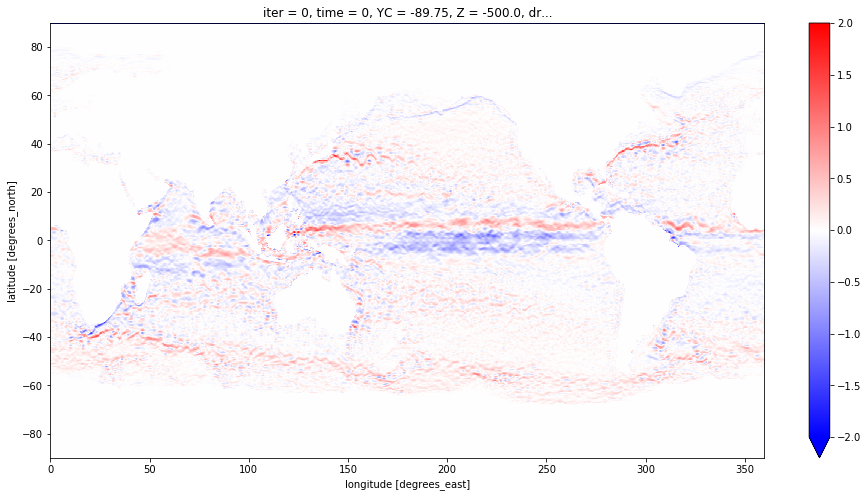

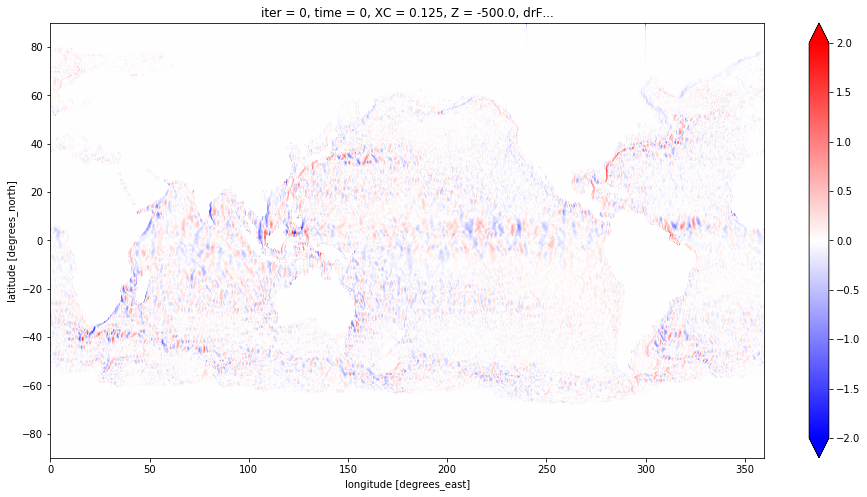

In [11]:
import numpy as np
import cartopy.crs as ccrs
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt

ds = open_mdsdataset('H:/AVISO/adtRun/', prefix='Stat', delta_t=86400)

dyG = ds['dyG']
dxG = ds['dxG']
drF = ds['drF']
psi = ds['PsiVEL'][0,...] # [t, y, x]

u_psi = -(np.roll(psi, -1, axis=0) - psi)/dyG[0,:]/drF
v_psi =  (np.roll(psi, -1, axis=1) - psi)/dxG[:,0]/drF

plt.figure(figsize=(16,8))
u_psi[...,0].plot.imshow(vmin=-2, vmax=2, cmap='bwr')

plt.figure(figsize=(16,8))
v_psi[...,0].plot.imshow(vmin=-2, vmax=2, cmap='bwr')

#### References:
https://github.com/rabernat/mitgcm_2D_global/blob/master/notebooks/correction.ipynb